In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import keras
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc #garbage collector for cleaning deleted data

Using TensorFlow backend.


In [3]:
# import os
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/My Drive/Coding_and_Projects/Cats_and_Dogs_Detection_Kaggle')
# os.chdir('/home/kishore/PythonProjects/Cats_and_Dogs_Detection/')
print(os.listdir("input"))

['train', 'test', 'train.zip', 'test.zip']


In [4]:
train_dir = 'input/train'
test_dir = 'input/test'
train_dogs = ['input/train/{}'.format(i) for i in os.listdir(train_dir) if 'dog' in i]   #dog images
train_cats = ['input/train/{}'.format(i) for i in os.listdir(train_dir) if 'cat' in i]   #cat images

test_imgs = ['input/test/{}'.format(i) for i in os.listdir(test_dir)]      #get test images

train_imgs = train_dogs[:2000] + train_cats[:2000]
random.shuffle(train_imgs)


In [5]:
print(len(train_dogs))
print(len(train_cats))
print(len(test_imgs))

# del(train_dogs)
# del(train_cats)
# gc.collect()

12500
12500
12500


In [6]:
# Counting number of files in the extracted directory
path, dirs, files = next(os.walk("input/train"))
file_count = len(files)
print(file_count)

25000


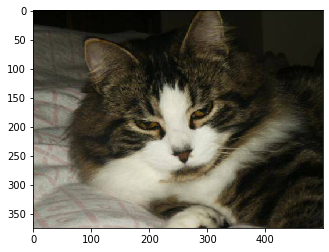

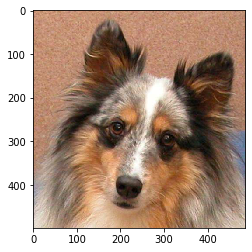

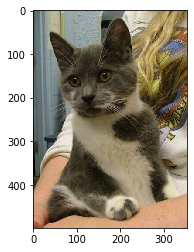

In [7]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img = mpimg.imread(ima)
    implot = plt.imshow(img)
    plt.show()

In [10]:
nrows, ncols = 150, 150
channel = 3    #channnel 1 is for greyscale

In [11]:
# print(train_imgs[0])
(cv2.imread(train_imgs[0])).shape

(375, 499, 3)

In [13]:
def read_and_procecss_images(list_of_images):
    X = []   #images
    y = []   #labels
    
    for img in list_of_images:
        X.append(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nrows,ncols), interpolation = cv2.INTER_CUBIC))  #read image
        if 'dog' in img:
            y.append(1)
        elif 'cat' in img:
            y.append(0)
    return X, y

X, y = read_and_procecss_images(train_imgs)

In [14]:
# X[0]

In [15]:
# y

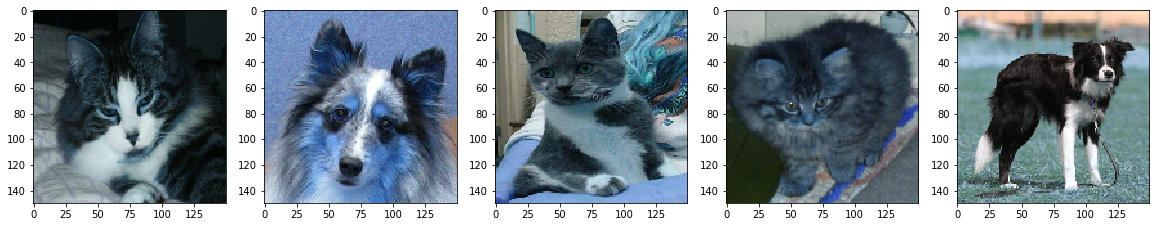

In [16]:
plt.figure(figsize = (20,10))
cols = 5
for i in range(cols):
    plt.subplot(5/cols +1, cols, i+1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels of cats and dogs')

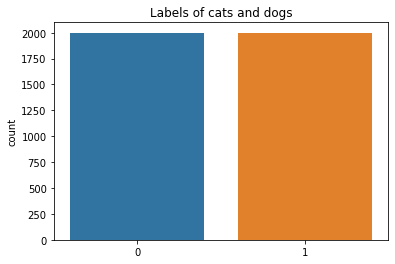

In [17]:
import seaborn as sn

del train_imgs
gc.collect()

# Conver list into arrays
X = np.array(X)
y = np.array(y)

sn.countplot(y)
plt.title('Labels of cats and dogs')

In [18]:
print('Shape of train images: ', X.shape)
print('Shape of labels: ', y.shape)

Shape of train images:  (4000, 150, 150, 3)
Shape of labels:  (4000,)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 2)

print('Shape of Train images: ', X_train.shape)
print('Shape of Validation images: ', X_val.shape)
print('Shape of Train Labels: ', y_train.shape)
print('Shape of Validation Labels: ', y_val.shape)

Shape of Train images:  (3200, 150, 150, 3)
Shape of Validation images:  (800, 150, 150, 3)
Shape of Train Labels:  (3200,)
Shape of Validation Labels:  (800,)


In [20]:
del X
del y
gc.collect()

ntrain = len(X_train)
nval = len(X_val)

# Note: Batch size must always be a factor of 2 """2, 4, 8, 16, 32, 64"""
batch_size = 32

In [21]:
from keras import layers
from keras import models
from keras import optimizers
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))      #Dropout for regularisation
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))   #Sigmoid function in the end bcz we need just two classes 

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [24]:
# We'll use RMSprop optimizer with learning rate of 0.0001
# We'll use BinaryCrossEntropy loss bcz it's a binary classification
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['acc'])

In [25]:
# Lets create the augmentation configuration
#  This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255, # Scale images between 0 and 1)
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255) #We do not augment validation data. We only perform rescale

In [26]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size = batch_size)

In [27]:
print(type(train_datagen))
print(type(train_generator))
print(len(train_generator))
print(len(val_generator))

<class 'keras.preprocessing.image.ImageDataGenerator'>
<class 'keras.preprocessing.image.NumpyArrayIterator'>
100
25


In [28]:
# Training part
# We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain//batch_size,
                             epochs = 100,
                             validation_data = val_generator,
                             validation_steps = nval//batch_size)

Epoch 1/100
100/100 [==============================] - 132s 1s/step - loss: 0.6927 - acc: 0.5122 - val_loss: 0.6877 - val_acc: 0.5788
Epoch 2/100
100/100 [==============================] - 129s 1s/step - loss: 0.6766 - acc: 0.5656 - val_loss: 0.6294 - val_acc: 0.6025
Epoch 3/100
  7/100 [=>............................] - ETA: 1:54 - loss: 0.6505 - acc: 0.6027

KeyboardInterrupt: 

In [ ]:
# Save the model
model.save_weights('model_weights.h5')
model.save('model.keras.h5')

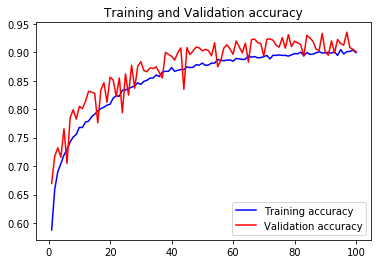

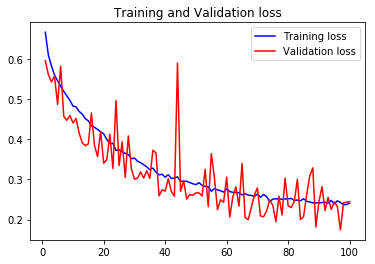

In [ ]:
# Lets polt train and val curve
# get details from history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Train and Validation accuracy
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
# Train and Validation loss
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
# Now lets predict first 10 images of the test set
X_test, y_test = read_and_procecss_images(test_imgs[0:10])
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
i = 0
text_labels = []
plt.figure(figsize = (30,20))
for batch in test_datagen.flow(x ,batch_size=1):
    pred = model.predict(batch)
    if pred >= 0.5:
        text_labels.append('dog. Acc = ' + str(pred))
    else:
        text_labels.append('cat. Acc = ' + str(1-pred))
    plt.subplot(5 / cols + 1, cols, i+1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if (i%10) == 0:
        break
plt.show()
    

NameError: name 'test_datagen' is not defined

<Figure size 2160x1440 with 0 Axes>

In [ ]:
# history2 = model.fit_generator(train_generator,
#                              steps_per_epoch = ntrain//batch_size,
#                              epochs = 200,
#                              validation_data = val_generator,
#                              validation_steps = nval//batch_size)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


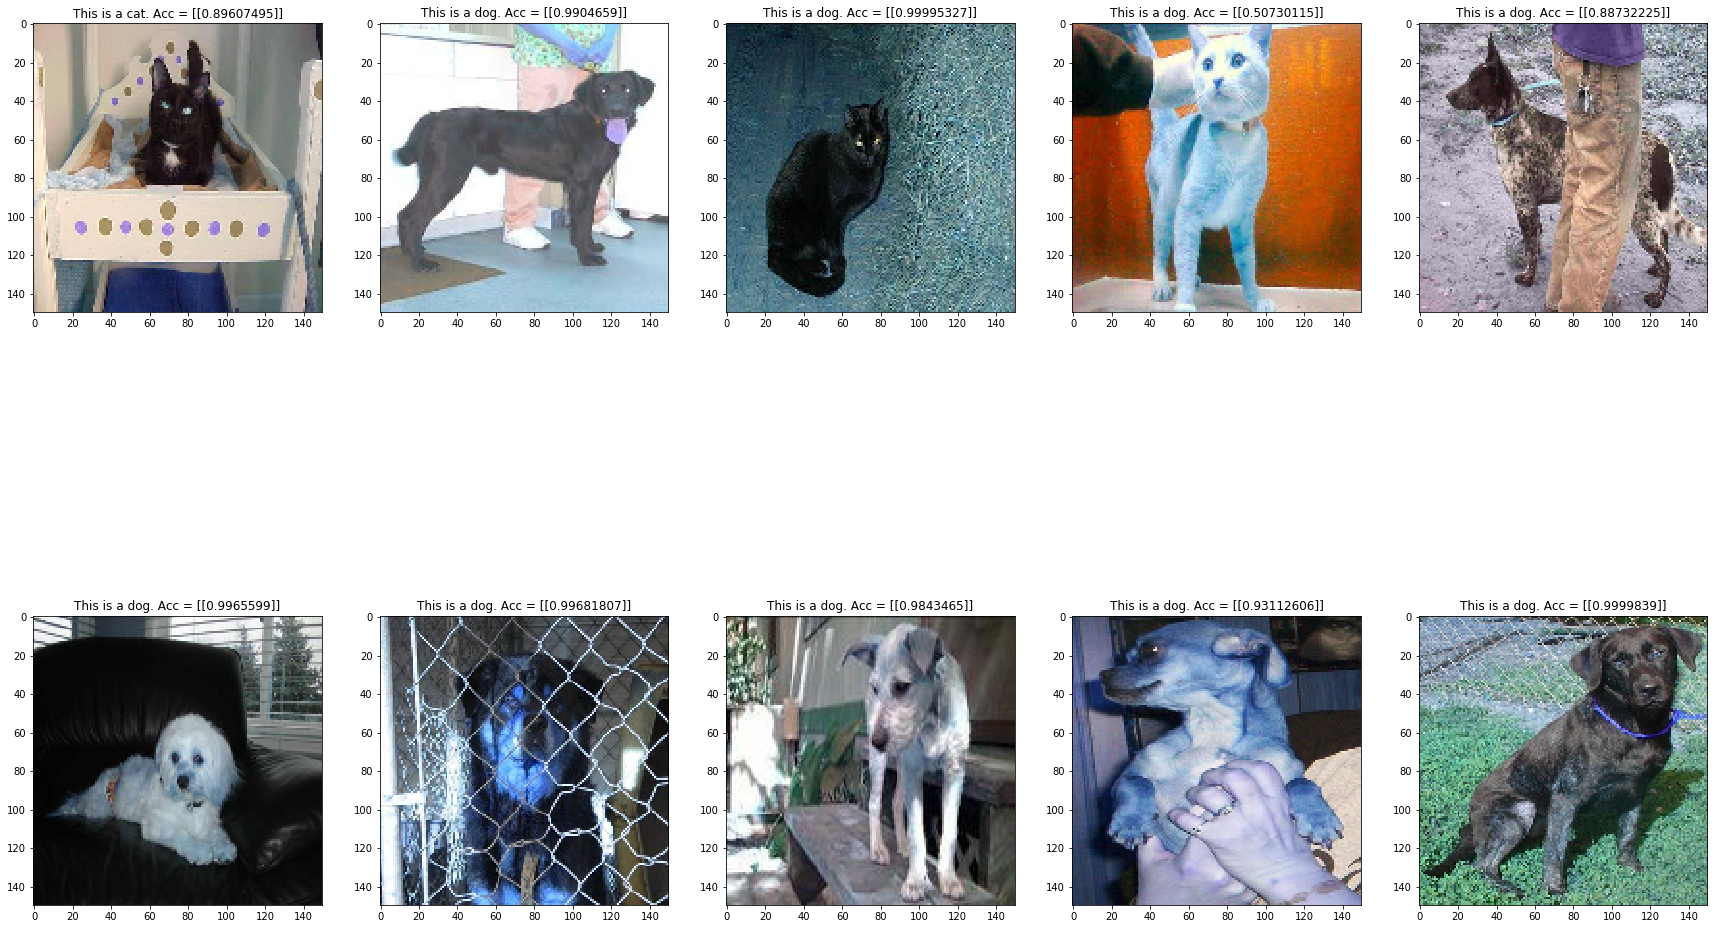

In [ ]:
i = 0
text_labels = []
plt.figure(figsize = (30,20))
for batch in test_datagen.flow(x ,batch_size=1):
    pred = loaded_model.predict(batch)
    if pred >= 0.5:
        text_labels.append('dog. Acc = ' + str(pred))
    else:
        text_labels.append('cat. Acc = ' + str(1-pred))
    plt.subplot(5 / cols + 1, cols, i+1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if (i%10) == 0:
        break
plt.show()
    

In [ ]:
with open("model.json", "r") as json_file:
    print(json_file.readlines())

['{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "batch_input_shape": [null, 150, 150, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_1", "trainable": true, "pool_size": [2, 2], "padding": "valid", "strides": [2, 2], "data_format": "channels_last"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "filters": 64, 